In [152]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
import plotly.graph_objs as go
import plotly.express as px
from sklearn.metrics import accuracy_score
import random

In [111]:
data_to_extract=pd.read_csv("..\chapter4\data_to_extraction.csv").drop(columns="Unnamed: 0")
data_to_extract.columns

Index(['PACJENT_NR', 'BADANIE_NR', 'BETET', 'CO2TET', 'HCO3ACTE', 'HCO3STTE',
       'O2SATTET', 'O2TET', 'IONH', 'ZGON', 'BETET_kw', 'O2TET_kw',
       'HCO3ACTE_kw', 'HCO3STTE_kw', 'O2SATTET_kw', 'IONH_kw', 'CO2TET_kw',
       'BETET_pn', 'O2TET_pn', 'HCO3ACTE_pn', 'HCO3STTE_pn', 'O2SATTET_pn',
       'IONH_pn', 'CO2TET_pn', 'euclidean_kw', 'euclidean_kw_skum'],
      dtype='object')

In [112]:
y=data_to_extract.groupby("PACJENT_NR").last()["ZGON"].reset_index(drop=True)

In [342]:
var_columns=['BETET', 'CO2TET', 'HCO3ACTE', 'HCO3STTE',
       'O2SATTET', 'O2TET', 'IONH', 'BETET_kw', 'O2TET_kw',
       'HCO3ACTE_kw', 'HCO3STTE_kw', 'O2SATTET_kw', 'IONH_kw', 'CO2TET_kw',
       'BETET_pn', 'O2TET_pn', 'HCO3ACTE_pn', 'HCO3STTE_pn', 'O2SATTET_pn',
       'IONH_pn', 'CO2TET_pn', 'euclidean_kw', 'euclidean_kw_skum']


In [343]:
selected_features = {
    'minimum': None,
    'maximum': None,
    'mean': None,
    'median': None,
    'variance': None,
    'number_peaks': [{'n': 2}, {'n': 4}],
    'first_location_of_minimum': None,
    'first_location_of_maximum': None,
    'linear_trend': [{'attr': 'slope'}],
    'agg_linear_trend': [{
        'f_agg': 'mean',
        'chunk_len': 3,
        'attr': 'slope'
    }, {
        'f_agg': 'mean',
        'chunk_len': 6,
        'attr': 'slope'
    }]
}

extracted_features = pd.DataFrame()

for col in var_columns:
    features = extract_features(data_to_extract, column_id="PACJENT_NR", column_sort="BADANIE_NR", 
                                column_value=col, default_fc_parameters=selected_features)
    features.columns = [f"{col}" for col in features.columns]
    extracted_features = pd.concat([extracted_features, features], axis=1)

extracted_features 

Feature Extraction: 100%|██████████| 18/18 [00:03<00:00,  5.52it/s]


,BETET__minimum,BETET__maximum,BETET__mean,BETET__median,BETET__variance,BETET__number_peaks__n_2,BETET__number_peaks__n_4,BETET__first_location_of_minimum,BETET__first_location_of_maximum,"BETET__linear_trend__attr_""slope""",...,euclidean_kw_skum__mean,euclidean_kw_skum__median,euclidean_kw_skum__variance,euclidean_kw_skum__number_peaks__n_2,euclidean_kw_skum__number_peaks__n_4,euclidean_kw_skum__first_location_of_minimum,euclidean_kw_skum__first_location_of_maximum,"euclidean_kw_skum__linear_trend__attr_""slope""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_3__f_agg_""mean""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_6__f_agg_""mean"""
1,0.086957,6.260870,3.212790,3.065217,2.015770,7.0,3.0,0.020000,0.220000,-0.005501,...,30.210453,27.404957,182.042449,0.0,0.0,0.0,0.980000,0.913771,2.751726,5.494292
2,-0.043478,2.304348,1.332609,1.173913,0.531479,0.0,0.0,0.000000,0.900000,0.243083,...,11.802240,12.681734,24.929782,0.0,0.0,0.0,0.800000,1.700442,4.159130,8.097602
3,0.478261,4.086957,2.179745,1.934783,0.734497,6.0,2.0,0.000000,0.243902,-0.033162,...,12.019851,13.150883,22.519226,0.0,0.0,0.0,0.926829,0.370867,1.079482,2.155931
4,-0.065217,3.500000,1.605499,1.456522,0.630021,4.0,1.0,0.705882,0.176471,-0.034773,...,5.707979,3.322259,23.542215,0.0,0.0,0.0,0.970588,0.397114,1.321238,2.571625
6,-0.043478,0.847826,0.478261,0.554348,0.067580,1.0,0.0,0.750000,0.375000,-0.054348,...,2.954789,3.884671,2.745903,0.0,0.0,0.0,0.750000,0.667426,1.736074,1.911147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.652174,5.347826,3.311141,3.358696,1.228126,4.0,2.0,0.031250,0.343750,0.032322,...,19.191855,21.141825,149.693755,0.0,0.0,0.0,0.968750,1.314109,3.895106,7.393326
140,-0.347826,3.934783,2.571558,2.869565,1.115528,4.0,1.0,0.000000,0.583333,0.081749,...,9.358543,10.248772,17.831701,0.0,0.0,0.0,0.958333,0.604629,1.813145,3.614941
142,0.391304,4.565217,2.884058,2.913043,1.841675,2.0,1.0,0.047619,0.666667,0.148278,...,22.226191,22.031082,178.999056,0.0,0.0,0.0,0.952381,2.196274,6.576850,12.499477
144,0.739130,3.282609,2.029644,1.956522,0.518755,0.0,0.0,0.000000,0.909091,0.189921,...,21.873042,22.452800,115.582655,0.0,0.0,0.0,0.909091,3.392153,9.627781,18.755566


In [326]:
names=extracted_features.columns

In [327]:
data_to_extract[['PACJENT_NR', 'ZGON']].groupby("PACJENT_NR").last()["ZGON"].reset_index()

,PACJENT_NR,ZGON
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,6,0.0
...,...,...
102,139,0.0
103,140,1.0
104,142,0.0
105,144,0.0


In [328]:
data_with_features=pd.concat([data_to_extract[['PACJENT_NR', 'ZGON']].groupby("PACJENT_NR").last()["ZGON"], extracted_features], axis=1).rename_axis("PACJENT_NR").reset_index()
data_with_features

,PACJENT_NR,ZGON,BETET__minimum,BETET__maximum,BETET__mean,BETET__median,BETET__variance,BETET__number_peaks__n_2,BETET__number_peaks__n_4,BETET__first_location_of_minimum,...,euclidean_kw_skum__mean,euclidean_kw_skum__median,euclidean_kw_skum__variance,euclidean_kw_skum__number_peaks__n_2,euclidean_kw_skum__number_peaks__n_4,euclidean_kw_skum__first_location_of_minimum,euclidean_kw_skum__first_location_of_maximum,"euclidean_kw_skum__linear_trend__attr_""slope""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_3__f_agg_""mean""","euclidean_kw_skum__agg_linear_trend__attr_""slope""__chunk_len_6__f_agg_""mean"""
0,1,0.0,0.086957,6.260870,3.212790,3.065217,2.015770,7.0,3.0,0.020000,...,30.210453,27.404957,182.042449,0.0,0.0,0.0,0.980000,0.913771,2.751726,5.494292
1,2,0.0,-0.043478,2.304348,1.332609,1.173913,0.531479,0.0,0.0,0.000000,...,11.802240,12.681734,24.929782,0.0,0.0,0.0,0.800000,1.700442,4.159130,8.097602
2,3,0.0,0.478261,4.086957,2.179745,1.934783,0.734497,6.0,2.0,0.000000,...,12.019851,13.150883,22.519226,0.0,0.0,0.0,0.926829,0.370867,1.079482,2.155931
3,4,0.0,-0.065217,3.500000,1.605499,1.456522,0.630021,4.0,1.0,0.705882,...,5.707979,3.322259,23.542215,0.0,0.0,0.0,0.970588,0.397114,1.321238,2.571625
4,6,0.0,-0.043478,0.847826,0.478261,0.554348,0.067580,1.0,0.0,0.750000,...,2.954789,3.884671,2.745903,0.0,0.0,0.0,0.750000,0.667426,1.736074,1.911147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,139,0.0,0.652174,5.347826,3.311141,3.358696,1.228126,4.0,2.0,0.031250,...,19.191855,21.141825,149.693755,0.0,0.0,0.0,0.968750,1.314109,3.895106,7.393326
103,140,1.0,-0.347826,3.934783,2.571558,2.869565,1.115528,4.0,1.0,0.000000,...,9.358543,10.248772,17.831701,0.0,0.0,0.0,0.958333,0.604629,1.813145,3.614941
104,142,0.0,0.391304,4.565217,2.884058,2.913043,1.841675,2.0,1.0,0.047619,...,22.226191,22.031082,178.999056,0.0,0.0,0.0,0.952381,2.196274,6.576850,12.499477
105,144,0.0,0.739130,3.282609,2.029644,1.956522,0.518755,0.0,0.0,0.000000,...,21.873042,22.452800,115.582655,0.0,0.0,0.0,0.909091,3.392153,9.627781,18.755566


In [330]:
random.seed(123)  
sample_zgon = random.sample(list(data_with_features[data_with_features["ZGON"] ==1].index), 15)
sample_nzgon = random.sample(list(data_with_features[data_with_features["ZGON"] ==0].index), 15)
indexes=[*sample_zgon, *sample_nzgon]
pacjenci_30 = data_with_features.loc[data_with_features.index.isin(indexes)].index
pacjenci_77 = data_with_features.loc[~data_with_features.index.isin(indexes)].index
train_data=data_with_features.iloc[pacjenci_77].drop(columns="PACJENT_NR")
test_data=data_with_features.iloc[pacjenci_30].drop(columns="PACJENT_NR")

In [331]:
X_train=train_data.drop(columns="ZGON")
y_train=train_data["ZGON"]

X_test=test_data.drop(columns="ZGON")
y_test=test_data["ZGON"]

In [355]:
X_data = data_with_features.drop(columns=["ZGON", "PACJENT_NR"])
y_data = data_with_features["ZGON"]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.2)

In [356]:
# Standaryzacja danych
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [357]:
X_train_scaled.shape

(85, 204)

In [358]:


# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train_scaled)

# Wyjaśniona wariancja
explained_variance_ratio = pca.explained_variance_ratio_

# Kumulatywna suma wyjaśnionej wariancji
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

# Tworzenie osypiska (scree plot) za pomocą Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(explained_variance_ratio) + 1)), y=explained_variance_ratio,
                         mode='lines+markers', name='Explained Variance Ratio'))
# fig.add_trace(go.Scatter(x=list(range(1, len(cumulative_explained_variance_ratio) + 1)), 
#                          y=cumulative_explained_variance_ratio,
#                          mode='lines+markers', name='Cumulative Explained Variance Ratio'))

# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title='Liczba składowych',
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='Odsetek wariancji',
        tickfont=dict(size=16),
        title_font=dict(size=20)
    )
)
fig.update_layout(template="plotly_white")


# Wyświetlenie wykresu
fig.show()
fig.write_image("images5/osypisko.png", width=1000, height=600, scale=3, format="png")

In [359]:
#PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))

X_pca_df=pd.DataFrame(X_train_pca, columns=['Czynnik 1', 'Czynnik 2', 'Czynnik 3'])
X_pca_df['ZGON'] = y
X_pca_df['Czy pacjent zmarł?'] = X_pca_df['ZGON'].map({1: 'tak', 0: 'nie'})

fig = px.scatter_3d(X_pca_df, x='Czynnik 1', y='Czynnik 2', z='Czynnik 3', color='Czy pacjent zmarł?', size_max=18, opacity=0.8)
fig.update_traces(textposition='top center', marker_size=6)

fig.update_layout(
    scene=dict(
        xaxis=dict(tickfont=dict(size=10)),
        yaxis=dict(tickfont=dict(size=10)),
        zaxis=dict(tickfont=dict(size=10)),
    )
)

fig.update_layout(legend=dict(font=dict(size=14)), legend_title=dict(font=dict(size=14)))
fig.update_layout(template="plotly_white")
fig.show()

fig.write_image("images5/" + "pca_miernik_3d" + ".png", width=1000, height=600, scale=3, format="png")


0.4134157365702835


In [360]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))

0.8533395104856147


In [361]:
# Klasyfikatory

classifiers = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']},
    'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
    'SVC': {'C': [0.1, 0.6,  1, 1.5, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]},
    'Random Forest': {'n_estimators': [5,10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [5,10, 20, 30, 40, 50]}
}


# Przechowywanie najlepszych modeli i ich wyników
best_models = {}
best_scores = {}

# Przeszukiwanie hiperparametrów dla każdego klasyfikatora
for name, classifier in classifiers.items():
    print(f"Przetwarzanie {name}...")
    grid_search = GridSearchCV(classifier, param_grids[name], cv=8, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_pca, y_train)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    print(f"Najlepsze parametry dla {name}: {grid_search.best_params_}")
    print(f"Najlepszy wynik dla {name}: {grid_search.best_score_}\n")

# Ocena najlepszych modeli na zbiorze testowym
for name, model in best_models.items():
    y_pred = model.predict(X_test_pca)
    test_score = accuracy_score(y_test, y_pred)
    print(f"Dokładność {name} na zbiorze testowym: {test_score}")

Przetwarzanie KNN...
Najlepsze parametry dla KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Najlepszy wynik dla KNN: 0.7625

Przetwarzanie LDA...
Najlepsze parametry dla LDA: {'solver': 'svd'}
Najlepszy wynik dla LDA: 0.7602272727272726

Przetwarzanie SVC...
Najlepsze parametry dla SVC: {'C': 1, 'kernel': 'sigmoid'}
Najlepszy wynik dla SVC: 0.7863636363636364

Przetwarzanie Decision Tree...
Najlepsze parametry dla Decision Tree: {'criterion': 'entropy', 'max_depth': 30}
Najlepszy wynik dla Decision Tree: 0.75

Przetwarzanie Random Forest...
Najlepsze parametry dla Random Forest: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 200}
Najlepszy wynik dla Random Forest: 0.7613636363636364

Dokładność KNN na zbiorze testowym: 0.7727272727272727
Dokładność LDA na zbiorze testowym: 0.8636363636363636
Dokładność SVC na zbiorze testowym: 0.8181818181818182
Dokładność Decision Tree na zbiorze testowym: 0.6818181818181818
Dokładność Random Forest na zbiorze testowym: 0.8181818181818182


In [362]:
best_models

{'KNN': KNeighborsClassifier(n_neighbors=7),
 'LDA': LinearDiscriminantAnalysis(),
 'SVC': SVC(C=1, kernel='sigmoid', probability=True),
 'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=30),
 'Random Forest': RandomForestClassifier(max_depth=30, n_estimators=200)}

Classification Report for KNeighborsClassifier:
               precision    recall  f1-score   support

         0.0       0.69      1.00      0.81        11
         1.0       1.00      0.55      0.71        11

    accuracy                           0.77        22
   macro avg       0.84      0.77      0.76        22
weighted avg       0.84      0.77      0.76        22

Time taken: 0.0010001659393310547 seconds
Classification Report for LinearDiscriminantAnalysis:
               precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        11
         1.0       0.90      0.82      0.86        11

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22

Time taken: 0.0010004043579101562 seconds
Classification Report for SVC:
               precision    recall  f1-score   support

         0.0       0.77      0.91      0.83        11
         1.0     

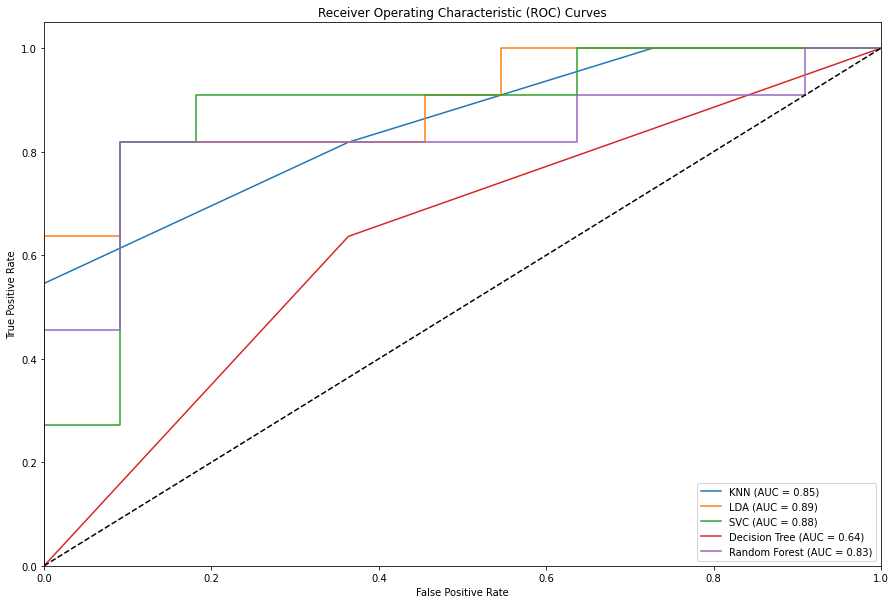

In [363]:
# Funkcja do trenowania i mierzenia czasu
def train_and_evaluate(classifier, X_train, X_test, y_train, y_test):
    start_time = time.time()
    classifier.fit(X_train, y_train)
    end_time = time.time()
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"Classification Report for {classifier.__class__.__name__}:\n", classification_report(y_test, y_pred))
    print(f"Time taken: {end_time - start_time} seconds")
    return fpr, tpr, roc_auc, end_time - start_time


# Krzywe ROC
plt.figure(figsize=(15, 10))
for name, classifier in best_models.items():
    fpr, tpr, roc_auc, _ = train_and_evaluate(classifier, X_train_pca, X_test_pca, y_train, y_test)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


AttributeError: 'RFECV' object has no attribute 'cv_results_'

Index(['BETET__mean', 'BETET__median', 'O2SATTET__median', 'IONH__mean',
       'IONH__median', 'IONH_kw__mean', 'IONH_kw__variance',
       'IONH_kw__first_location_of_maximum',
       'IONH_kw__agg_linear_trend__attr_"slope"__chunk_len_3__f_agg_"mean"',
       'IONH_kw__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"',
       'CO2TET_kw__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"',
       'BETET_pn__median', 'O2TET_pn__mean', 'IONH_pn__maximum',
       'IONH_pn__mean', 'IONH_pn__variance',
       'IONH_pn__first_location_of_maximum',
       'IONH_pn__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"',
       'euclidean_kw__mean',
       'euclidean_kw_skum__agg_linear_trend__attr_"slope"__chunk_len_6__f_agg_"mean"'],
      dtype='object')
Classification Report for KNeighborsClassifier:
               precision    recall  f1-score   support

         0.0       0.69      0.82      0.75        11
         1.0       0.78      0.64      0.70        11

    

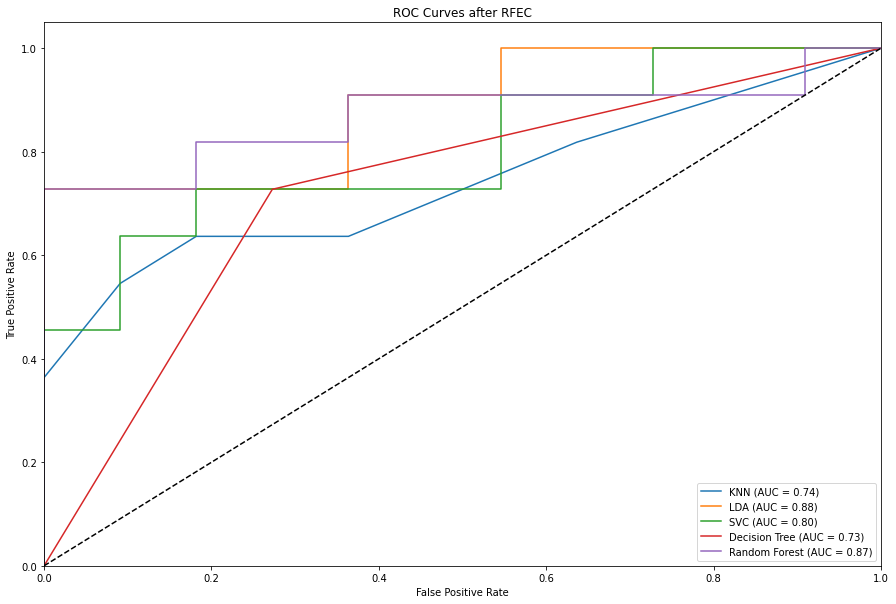

Best Model Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.73      0.76        11
         1.0       0.75      0.82      0.78        11

    accuracy                           0.77        22
   macro avg       0.78      0.77      0.77        22
weighted avg       0.78      0.77      0.77        22



In [368]:
# RFEC (Recursive Feature Elimination with Cross-Validation)
selector = RFE(RandomForestClassifier(),n_features_to_select = 20, step=1)
selector = selector.fit(X_train_scaled, y_train)

selected_columns = names[selector.support_]
print(selected_columns)

X_train_rfe = selector.transform(X_train_scaled)
X_test_rfe = selector.transform(X_test_scaled)

# Krzywe ROC po RFEC
plt.figure(figsize=(15, 10))
for name, classifier in classifiers.items():
    fpr, tpr, roc_auc, _ = train_and_evaluate(classifier, X_train_rfe, X_test_rfe, y_train, y_test)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves after RFEC')
plt.legend(loc='lower right')
plt.show()

# Interpretacja metryk dla najlepszego modelu
# Zakładamy, że najlepszy model to RandomForestClassifier
best_model = RandomForestClassifier()
best_model.fit(X_train_rfe, y_train)
y_pred_best = best_model.predict(X_test_rfe)
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

# Zbadanie modeli w czasie
# times = {}
# for name, classifier in classifiers.items():
#     _, _, _, training_time = train_and_evaluate(classifier, X_train, X_test, y_train, y_test)
#     times[name] = training_time

# print("Training times for each classifier:")
# for name, t in times.items():
#     print(f"{name}: {t:.4f} seconds")


In [365]:
from sklearn.feature_selection import RFECV

In [366]:
y_train.shape

(85,)

In [370]:

# Definicja klasyfikatorów
classifiers = {
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Definicja siatek parametrów
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']},
    'LDA': {'solver': ['svd', 'lsqr', 'eigen']},
    'SVC': {'C': [0.1, 0.6,  1, 1.5, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]},
    'Random Forest': {'n_estimators': [5, 10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20, 30, 40, 50]}
}

# Przygotowanie wyników
results = {}

# Przetwarzanie każdego klasyfikatora
for name, model in classifiers.items():
    print(f"Processing {name}...")
    param_grid = param_grids[name]

    # GridSearchCV to optymalizacja hiperparametrów
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

    # RFECV z GridSearchCV jako estymatorem
    rfecv = RFECV(estimator=grid_search, step=1, cv=5, scoring='accuracy')
    
    # Dopasowanie RFECV do danych
    rfecv.fit(X_train_scaled, y_train)
    
    # Zapisanie wyników
    results[name] = {
        'best_score': rfecv.grid_scores_.max(),
        'best_params': rfecv.estimator_.best_params_,
        'n_features': rfecv.n_features_,
        'support': rfecv.support_,
        'ranking': rfecv.ranking_
    }
    
    print(f"Best score for {name}: {results[name]['best_score']}")
    print(f"Best params for {name}: {results[name]['best_params']}")
    print(f"Number of features selected: {results[name]['n_features']}")

y_pred_best =rfecv.predict(X_test_rfe)
print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))

Processing KNN...


ValueError: when `importance_getter=='auto'`, the underlying estimator GridSearchCV should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
min_features_to_select=1
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    # yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()